In [1]:
import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import pandas
import numpy as np

from d_code.imaging.io import tifffile
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns


import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline
#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())


This non-commercial license of GraphLab Create is assigned to stanlp86@gmail.com and will expire on October 28, 2016. For commercial licensing options, visit https://dato.com/buy/.


2016-05-08 18:13:03,171 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1462745582.log


# Paths 


In [2]:


qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/sp041216a/'
sframePath = '/Users/Stan/Desktop/sp041216a/tracesDFfromTrial/sframe_processed'
rawTraces_e2_Path = '/Users/Stan/Desktop/sp041216a/e2_traces_dict.dat'
rawTraces_e3_Path = '/Users/Stan/Desktop/sp041216a/e3_traces_dict.dat'
workflowDict_e2_Path = '/Users/Stan/Desktop/sp041216a/workflow_dict_e2.dat'
workflowDict_e3_Path = '/Users/Stan/Desktop/sp041216a/workflow_dict_e3.dat'
odorInfoPath = '/Users/Stan/Desktop/sp041216a/odorInfo.dat'

In [3]:
experiment = 'sp041216a'

 # save/load

In [ ]:
#trials used for making e3_traces_dict
'10,11,12,13,14,15,16,17,18,19,20'

In [4]:
#workflow_dict = pickle.load(open(workflowDict_e1_Path))
rawTraces = pickle.load(open(rawTraces_e2_Path))['rois']['reshaped']
def save_dict():
    pickle.dump(workflow_dict, open(workflowDict_e2_Path, 'wb'))

In [5]:
epochIDX = 2
sframe = gl.SFrame(sframePath)
df = sframe[sframe['epoch']==epochIDX]['Frame', 'RoiSignal', 'cellID', 'trial', 'normed_traces', 'normed_stds', 'baselined1_traces'].to_dataframe()
groups = df.groupby(['trial', 'cellID'])
epoch = groups.apply(lambda x: x.reset_index(drop = True))

# get dimensions 
frames, cells, trials = [epoch.loc[(10,1)]['RoiSignal'].size] + [epoch[_].unique().shape[0] for _ in ['cellID','trial']]


 # Make sure ordering is correct for traces. 

/Users/Stan/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


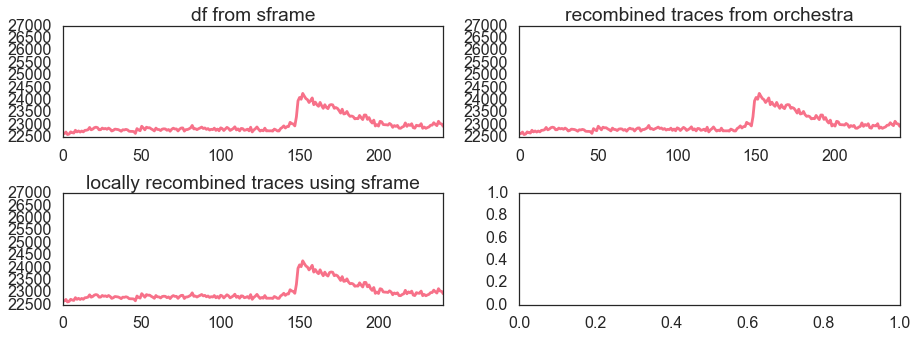

In [7]:
cell = 100
trial = 10
sframeTrace = sframe[(sframe['epoch']==epochIDX)&(sframe['trial']==trial)&(sframe['cellID']==cell)]['RoiSignal']

plt.subplots(2,2, figsize = (15,5))
plt.subplot(2,2,1),plt.plot(df[df.trial==trial][df.cellID==cell].RoiSignal.values), plt.xlim(0,241)
plt.title('df from sframe')
plt.subplot(2,2,2), plt.plot(rawTraces[:,cell,0]), plt.xlim(0,241)
plt.title('recombined traces from orchestra')

plt.subplot(2,2,3), plt.plot(sframeTrace), plt.xlim(0,241)
plt.title('locally recombined traces using sframe')

## Initialize dict

In [8]:
workflow_dict = defaultdict(dict)
# workflow_dict['raw_traces'] = traces
# workflow_dict['numCells'] = traces.shape[1]
# workflow_dict['numTrials'] = traces.shape[2]
# workflow_dict['numOdors'] = 8 #change this line
# workflow_dict['normed_traces']['corrected_rois'] = 
# workflow_dict['normed_traces']['normed_stds'] =

Get trialNames from traces dataframe and make sure it corresponds with odor_info

# Load odor info


In [9]:
odor_info = pickle.load(open(odorInfoPath))['epoch2']
trialIDList = []
for trial in odor_info:
    trialIDList.append(trial['trialID'])

In [10]:
#Correspondence Check
list(epoch.trial.unique()) == trialIDList

True

In [11]:
trialIndexingHelper = zip(range(len(trialIDList)),trialIDList)

In [12]:
    
workflow_dict['odor_info']= odor_info

## populate raw traces

In [13]:
traces = np.empty((trials,cells,frames))
for itrial, trialID in enumerate(trialIDList):
    traces[itrial,:,:] =  np.squeeze(epoch.loc[trialID][['RoiSignal']].to_panel().as_matrix())
traces = traces.T
workflow_dict['raw_traces'] = traces


## populate normed traces

In [14]:
normed_traces = np.empty((trials, cells, frames))
for itrial, trialID in enumerate(trialIDList):
    normed_traces[itrial,:,:] =  np.squeeze(epoch.loc[trialID][['normed_traces']].to_panel().as_matrix())
normed_traces = normed_traces.T
workflow_dict['normed_traces']['corrected_rois'] = normed_traces

## populate normed_stds

In [15]:
normed_stds = np.empty((cells,trials))
this = epoch.groupby(['trial', 'cellID']).apply(lambda x: x['normed_stds'].ix[0])
for itrial, trialID in enumerate(trialIDList):
    for cell in range(cells):
        normed_stds[cell,itrial] = this.loc[trialID, cell]
workflow_dict['normed_traces']['normed_stds'] = normed_stds

## populate baselines1 for SNR

In [16]:
baselines1 = np.empty((trials, cells, frames))
for itrial, trialID in enumerate(trialIDList):
        baselines1[itrial,:,:] = np.squeeze(epoch.loc[trialID][['baselined1_traces']].to_panel().as_matrix())
baselines1 = baselines1.T
workflow_dict['normed_traces']['baselines1'] = baselines1

## populate other

In [17]:
workflow_dict['numCells'] = cells
workflow_dict['numTrials'] = trials
workflow_dict['numOdors'] = 8 

# Filter shit cells and trials. 

In [ ]:
# #filter shit cells and trials.  

# #good_trials = [0,2,3,4,7,8,10,11,12,13,14]

# bad_cells = [866,864,327]

# cells = range(867)
# good_cells = [cell for cell in cells if cell not in bad_cells]

# normed_traces = np.squeeze(normed_traces[:,[good_cells],:])
# workflow_dict['normed_traces']['corrected_rois'] = normed_traces
# #filter stds. 

# normed_stds = np.squeeze(workflow_dict['normed_traces']['normed_stds'][good_cells])
# workflow_dict['normed_traces']['normed_stds'] = normed_stds

# # baselined1_traces = np.squeeze(workflow_dict['normed_traces']['baselined1_traces'][:,[good_cells],:])
# # workflow_dict['normed_traces']['baselined1_traces'] = baselined1_traces

In [ ]:
# #for SFRAME
# #remove bad cells trials etc. 

# blah = epoch1.drop([2,6,7,10])

# epoch1Filt = blah.copy()

# bad cells: edge cases: 866,864,327

# #get values to drop index
# obj = epoch1Filt.loc[range(1,16),[866,864,327],:].index.values

# epoch1Filt = epoch1Filt.drop(list(obj))

# get responders

In [18]:
from spUtils.FindSigResponses.sigTesting import getcellsBasic
numOdors = workflow_dict['numOdors']
numCells = workflow_dict['numCells']
numTrials = workflow_dict['numTrials']
normed_traces=workflow_dict['normed_traces']['corrected_rois']
window = 15 #frames... 2 seconds. 
responseDict = defaultdict(dict)

for cell in range(numCells):
    for odor in range(numOdors):
       
        responseDict[odor][cell] =  [trial for trial in getcellsBasic(workflow_dict, normed_traces, odor, cell, numTrials, window)]
        

In [19]:
#report number of trials (and identity) on which a response is detected. 
trial_thresh = 6
def filterSigCells(responseDict, odor, trial_thresh = 2):
    for cell, numTrials in responseDict[odor].items():
        if len(numTrials)>=trial_thresh:
            
            yield cell, numTrials


ResponsiveCellsbyOdor = {odor:{cell:numTrials for cell, numTrials in filterSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup


# Fraction of responsive population by odor

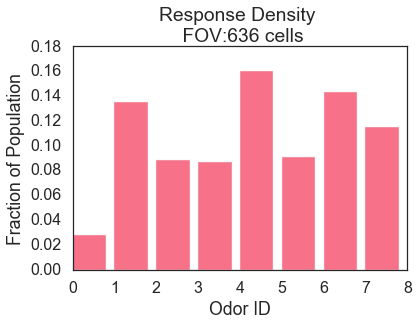

In [20]:

#report number of neurons that satisfy response criterion above. then take fraction.
FractionofPopulation= {key:len(numResponsiveCells) for key, numResponsiveCells in ResponsiveCellsbyOdor.iteritems()}
fractionofCells = np.asarray(FractionofPopulation.values())/float(numCells)
odorID = [odorIDX+1 for odorIDX in FractionofPopulation.keys()]

#Plot
plt.bar(FractionofPopulation.keys(), fractionofCells)#change odor range for new setup
plt.xlabel('Odor ID')
plt.ylabel('Fraction of Population')
plt.title('Response Density \n FOV:{} cells'.format(numCells))
plt.savefig('response_density_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

## Fraction of responsive population by odor 
- sorted by positive and negative changes. 


In [21]:
#number of detected deviations during odor period on 'trial_thresh' trials deems this a responding odor-cell pair.
trial_thresh = 6

In [22]:
def posSigCells(responseDict, odor, trial_thresh = 2):
    for cell, numTrials in responseDict[odor].items():
        if len(numTrials)>=trial_thresh:
            if sum(x>0 for x in numTrials)>=trial_thresh:
                yield cell, numTrials
def negSigCells(responseDict, odor, trial_thresh = 2):
    for cell, numTrials in responseDict[odor].items():
        if len(numTrials)>=trial_thresh:
            if sum(x<0 for x in numTrials)>=trial_thresh:
                yield cell, numTrials                
                

pos_responders = {odor:{cell:numTrials for cell, numTrials in posSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup
pos_cells = {odor:len(cell_list) for odor, cell_list in pos_responders.iteritems()}
fractionofPosCells = np.asarray(pos_cells.values())/float(numCells)
#print fractionofPosCells

neg_responders = {odor:{cell:numTrials for cell, numTrials in negSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup
neg_cells = {odor:len(cell_list) for odor, cell_list in neg_responders.iteritems()}
fractionofNegCells = np.asarray(neg_cells.values())/float(numCells)

#print fractionofNegCells

# plt.figure(figsize = (5,5))
# plt.bar(range(numOdors), sorted(fractionofPosCells), color =  'k', alpha = 0.5, label = 'excitatory')
# plt.bar(range(numOdors), sorted(fractionofNegCells), alpha = 0.5, label = 'suppressed') #change odor range for new setup
# plt.legend()
# #plt.ylim(0,0.2)
# plt.xlabel('Odor ID')
# plt.ylabel('Fraction of Population')
# plt.title('Response Density \n FOV:{} cells'.format(numCells))
#plt.savefig('ei_response_density.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)


# Promiscuous Cells. Those that respond to more than one odor. 
-This is calculated on cells that respond to an odor on at least 50 percent of the trials. 

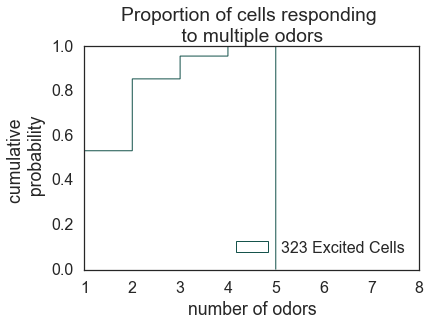

In [23]:
#obtain number of times a responding neuron was reliably detected upon presentations of multiple stimulii.

PosPromiscuousCells = defaultdict(int)
NegPromiscuousCells = defaultdict(int)
for odor in range(numOdors):
    for cell in pos_responders[odor].keys():   
        PosPromiscuousCells[cell] +=1
    for cell in neg_responders[odor].keys():  
        NegPromiscuousCells[cell] +=1
        
        
PosTotal = len(PosPromiscuousCells.values())
NegTotal = len(NegPromiscuousCells.values())


with sns.color_palette('cubehelix', 3):
    plt.hist(PosPromiscuousCells.values(), bins = list(set(PosPromiscuousCells.values())),
             histtype = 'step', linewidth = 1, cumulative = 1, normed = True, label = '{} Excited Cells'.format(PosTotal))
    plt.ylim(0,1)
    plt.xlim(1,8)
    plt.legend(loc='lower right')
#     plt.hist(NegPromiscuousCells.values(), bins = list(set(PosPromiscuousCells.values())), 
#              histtype = 'step', linewidth = 1, cumulative = 1, normed = True, label = '{} Suppressed Cells'.format(NegTotal))
#     plt.ylim(0,1)
#     plt.legend(loc = 'lower right')
    plt.title('Proportion of cells responding \n to multiple odors ')
    plt.xlabel('number of odors')
    plt.ylabel('cumulative \n probability')
    

plt.savefig('cells_across_odors_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [24]:
save_dict()

#           -Spread in the distribution of fluorescence by cell             - Normalized

In [ ]:
numOdors = workflow_dict['numOdors']
numCells = workflow_dict['numCells']
numTrials = workflow_dict['numTrials']

skew_list = []
for cell in range(numCells):
    a = normed_traces[:, cell,2].T.ravel()
    skew_list.append(scipy.stats.skew(a, bias=False))
a = np.hstack(skew_list)
skew = (a-np.mean(a))/np.std(a)

#plot distribution of skew values for all cells. 
plt.figure(figsize = (10,10))
plt.hist(skew, 20, log = 0, normed = 1, histtype='step', cumulative=1, label  = '{} cells'.format(numCells))
#plt.xlim(-1,2)
plt.xlabel('Skew')
plt.ylabel('Proportion of cells')
plt.title('Skew of Fluorecence distributions \n  for all cells')
print 'Average Skew = {0}'.format(skew.mean())
print 'Skew STD = {0}'.format(np.std(skew))
legend = plt.legend()

# # this is an inset axes over the main axes
# s = axes([.65, .5, .2, .2])


# cell = 30
# a = traces[:, cell,0]- traces[:, cell,0].mean()
# plt.axvline(a.mean())

# n, bins, patches = hist(a, 10, log=0)
# title('Raw Intensity \n cell 30; skew = 1.2 \n')
# setp(s, xticks=[], yticks=[])


# s = axes([.65, .2, .2, .2])

# cell = 102
# a = traces[:, cell,0]- traces[:, cell,0].mean()

# plt.axvline(a.mean())
# n, bins, patches = hist(a, 10, log=0)
# title('cell {}; skew = -1.78 \n'.format(cell))
# setp(s, xticks=[], yticks=[])
plt.savefig('/Users/Stan/Desktop/temp/norm_skew.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

# Events

In [25]:
from spUtils.get_normalized_traces_submodule import epoch_event_generator, findEventsParams

In [26]:
meta = pickle.load(open('/Users/Stan/Desktop/sp041216a/metadata/sp041216a_e2_010_003_slice_0_channel_0.dat'))
secPerFrame = meta['scanimage.SI5.scanFramePeriod'][0]
frameRate = secPerFrame
findEventsParams['minimum_length'] = int(1/frameRate/4)

In [27]:
normed_traces = next(spUtils.gen_dict_extract('corrected_rois', workflow_dict))
stds = workflow_dict['normed_traces']['normed_stds']#next(spUtils.gen_dict_extract('normed_stds', workflow_dict))
numTrials = workflow_dict['numTrials']
frames, cells, trials = normed_traces.shape

events=defaultdict(dict)
for key, val in [('pos_events',True), ('neg_events',False)]:
    findEventsParams['positive'] = val
    events[key] = epoch_event_generator(normed_traces, stds, cells, numTrials,**findEventsParams)

#store events and params
workflow_dict['events'] = events
workflow_dict['events']['params'] = findEventsParams
# save_dict()

#  Display distribution of event magnitudes  

In [28]:
from spUtils.get_normalized_traces_submodule import getMaxEvents

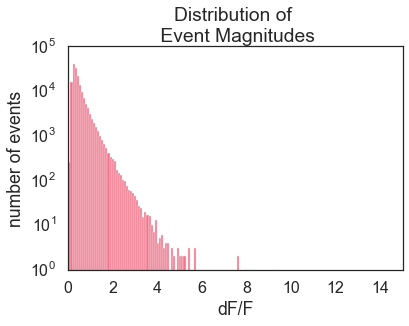

In [29]:
numCells = workflow_dict['numCells']
these_traces = normed_traces
these_events = workflow_dict['events']['pos_events']
    
eMags = getMaxEvents(these_events[:,:,:],these_traces[:,:,:])
workflow_dict['events']['max_events'] = eMags
#since each detected event consists of multiple identical contiguous values. The number of values corresponds to event length.
#the value corresponds to the average of the avent amplitude. 

eMags = list(np.unique(eMags[:,cell,:])[1:] for cell in range(numCells))
eMags_pooled = np.hstack(eMags)

plot = plt.hist(eMags_pooled, bins = 100, log = True)
plt.xlim(0, 15)
plt.title('Distribution of \n Event Magnitudes')
plt.xlabel('dF/F')
plt.ylabel('number of events')
plt.savefig('event_magnitudes_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)


#  Display distribution of event durations  

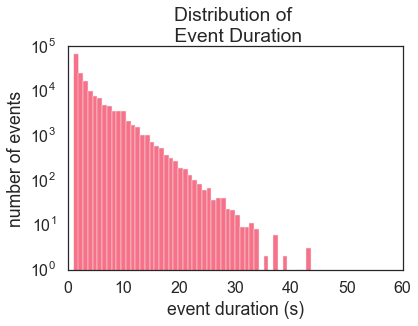

In [30]:
from  d_code.events import getStartsAndStops
from numpy import ma
from d_code.events import getDurations
#posDur = ma.getdata(getDurations(events['pos_events']))


posDur = getDurations(workflow_dict['events']['pos_events'])
condition = np.isfinite(posDur)
pos_event_durations = (np.extract(condition, posDur))#/fps
workflow_dict['events']['event_durations'] = pos_event_durations 
#ytick_list = [("%.2f" % a) for a in np.asarray(range(0,36292,4500))/float(PosTotal)]
#plt.hist(pos_event_durations/one_second, normed = True)
one_second = 1/secPerFrame/4
plot = plt.hist(pos_event_durations/one_second, bins = 50,log = True,)
plt.xlim(0,60)
#plt.yticks(range(0,36292,4500), ytick_list)

#plt.hist(pos_event_durations/10.)

plt.title('Distribution of \n Event Duration')
plt.ylabel('number of events')
plt.xlabel('event duration (s)')

plt.savefig('normed_event_duration_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [31]:
save_dict()

# Investigate outlier events.
- Ultimately, event-detection should not bias against an event of a particular duration. 

In [32]:
starts, stops = getStartsAndStops(workflow_dict['events']['pos_events'])

In [111]:
exceptionalEventDurations[eventID]

array([ 5, 10, 12])

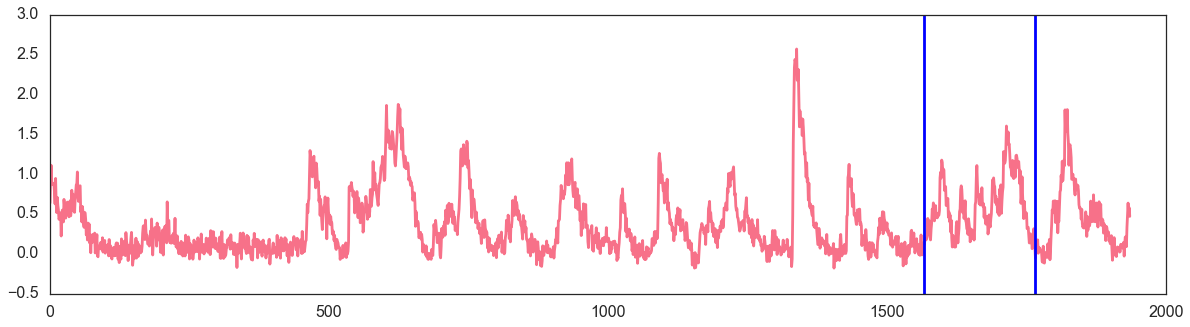

In [31]:

exceptionalEventDurations = np.argwhere(posDur/one_second>20)
eventID =18
cell, trial, this_event = exceptionalEventDurations[eventID]
duration = posDur[cell, trial, this_event]
i = starts[cell, trial, this_event]
j = stops[cell, trial, this_event]

#plot
plt.figure(figsize = (20,5))
plt.plot(normed_traces[:,cell,trial])
plt.axvline(i)
plt.axvline(j)

In [32]:
normed_traces.shape

(1936, 640, 11)

In [33]:
#All events all trials all cells divided by trial length
trial_length = secPerFrame*4*1936
Average_Event_Frequency = eMags_pooled.shape[0]/(numCells*numTrials)/trial_length#float(PosTotal)
Average_number_of_events_per_cell = eMags_pooled.shape[0]/numCells/numTrials

In [34]:
Average_Event_Frequency

0.089119776582950741

In [35]:
Average_number_of_events_per_cell

23

# Lifetime Sparseness

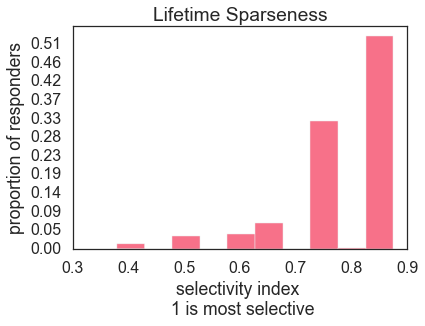

In [38]:
average_response_odor_cell = {'odor_{}'.format(odor) :{cell : np.mean([trials]) for cell, trials in pos_responders[odor].iteritems()} for odor in range(numOdors)}

#average_response_odor_cell = {'odor_{}'.format(odor) :{cell : np.mean([trials]) for cell, trials in neg_responders[odor].iteritems()} for odor in range(23)}

#get all responsive cells
hmm = defaultdict(list)
for odor in range(numOdors):
    hmm['odor_{}'.format(odor)] = [cell_list for cell_list in average_response_odor_cell['odor_{}'.format(odor)].iterkeys()] 
    
blah = hmm.values()
#for responsive cells only, get all resposes. 
c = []
for item in blah:
    c.append(item)
d = set(np.hstack(c))


response_list_by_cell = []

for cell in d: 
    
    a = spUtils.gen_dict_extract(cell, average_response_odor_cell)
    response_list_by_cell.append(np.asarray([item for item in a]))


LS_list = []
for cell, cell_responses in enumerate(response_list_by_cell):
    numerator = np.power(np.sum(np.absolute(cell_responses))/numOdors,2)
    denomenator = np.sum(np.power(cell_responses,2)/float(numOdors))
    LS_list.append(1-float(numerator)/denomenator)
LS_list = np.hstack(LS_list)

#


counts, values = np.histogram(LS_list)
numResponders = LS_list.shape[0]
ytick_interval = 15

plot = plt.hist(LS_list)
ytick_list = [("%.2f" % a) for a in np.asarray(range(0,counts.max(),ytick_interval))/float(numResponders)]
ticks = plt.yticks(range(0,counts.max(),ytick_interval), ytick_list)
plt.title('Lifetime Sparseness')
plt.xlabel('selectivity index \n 1 is most selective')
plt.ylabel('proportion of responders')
plt.savefig('LS_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)


## Plot trial-averaged responses by odor

### extract odor onset for all trials

In [39]:
odor_info = spUtils.gen_dict_extract('odor_info', workflow_dict).next()

odor_on_times_by_trial = defaultdict(list)
for odor in range(1,numOdors+1):
    for trial in range(numTrials):
        odor_on_times_by_trial[odor].append(odor_info[trial]['on'][odor])
        
odor_off_times_by_trial = defaultdict(list)
for odor in range(1,numOdors+1):
    for trial in range(numTrials):
        odor_off_times_by_trial[odor].append(odor_info[trial]['off'][odor])
        
odor_interval_by_trial = defaultdict(list)
for odor in range(1,numOdors+1):
    for trial in range(numTrials):
        odor_interval_by_trial[odor].append(odor_info[trial]['pre_odor_post_interval'][odor])

In [40]:
odor = 2

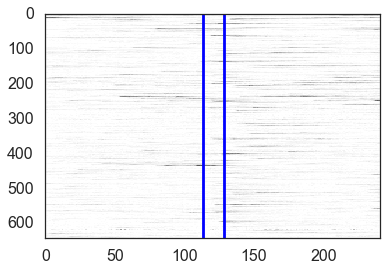

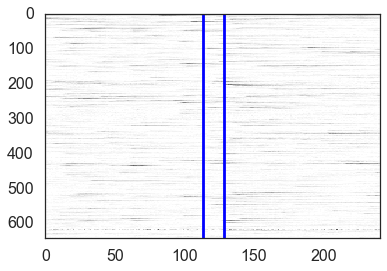

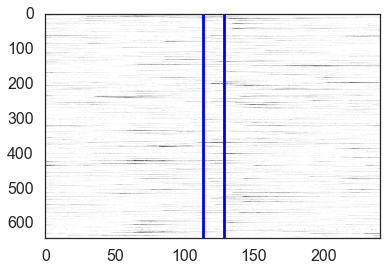

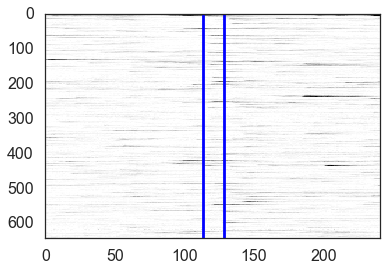

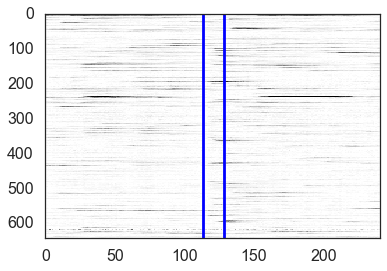

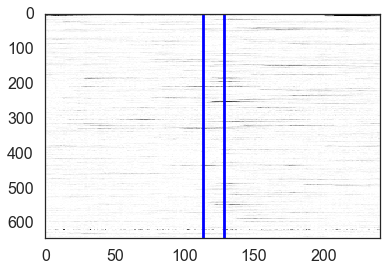

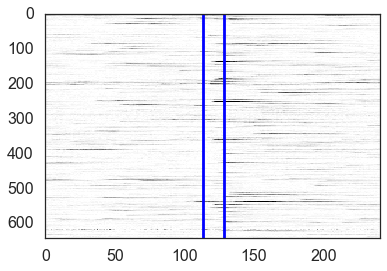

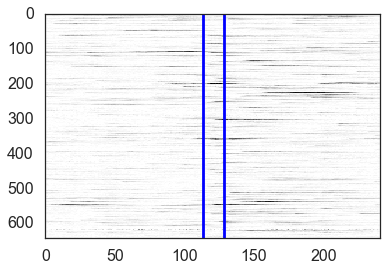

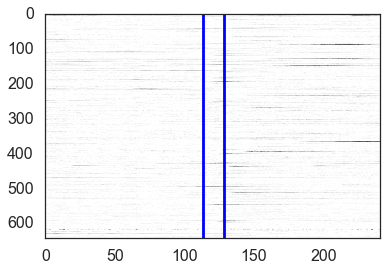

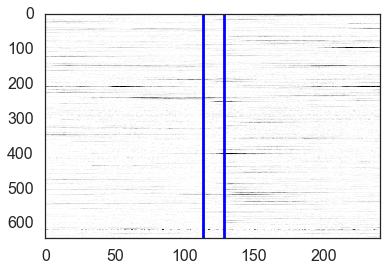

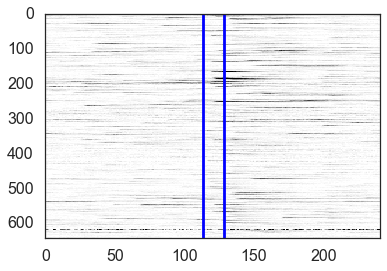

In [39]:
for trial in range(numTrials):
    plt.figure()
    sta, sto  = odor_interval_by_trial[odor][trial]
    slice_  = slice(sta,sto,1)
    plt.imshow(normed_traces[slice_,:,trial].T, aspect = 'auto')
    plt.axvline(113)
    plt.axvline(128)
    plt.clim(0,3)

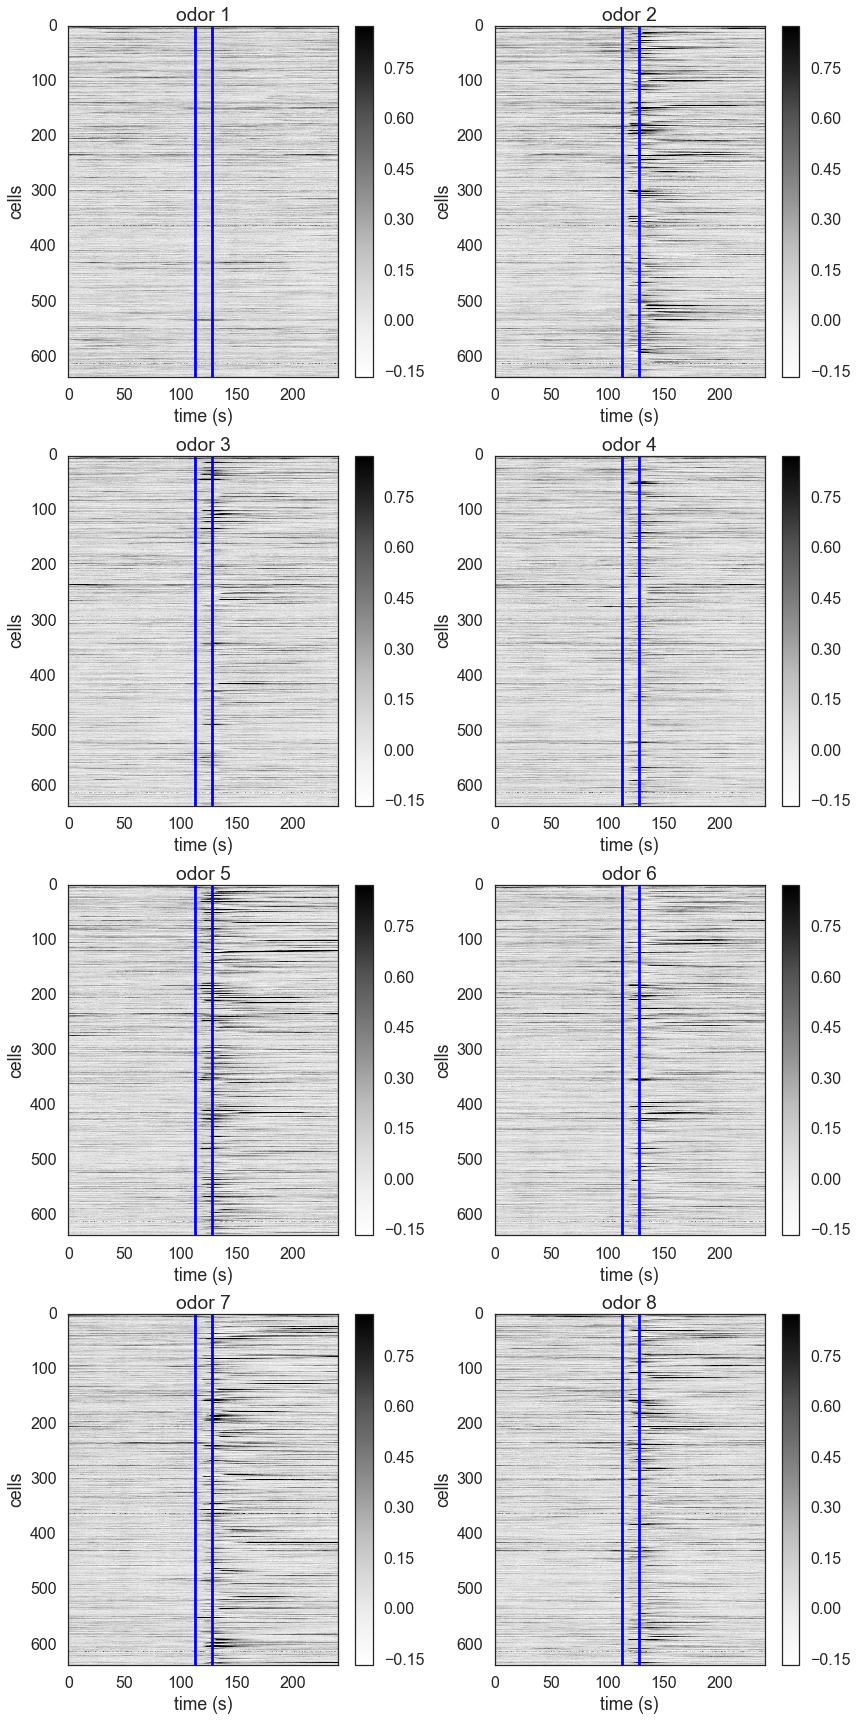

In [41]:
from scipy.stats.mstats import mquantiles
min_, max_ = mquantiles(normed_traces[...,:].flatten(),  prob=[0.02, .98])
idxs = np.vstack(odor_interval_by_trial[odor])
offset = 113
nro=numOdors/2
nco=2
plt.subplots(nro,nco, sharex=True, sharey=True, figsize = (3*nro,12*nco))
for idx, odor in enumerate(range(1,numOdors+1)):
    aa = []
    title = 'odor {}'.format(odor)#odor_info[0]['odor_names'][idx][1]
    for trial in range(numTrials):
        sta, sto  = odor_interval_by_trial[odor][trial]
        test  = slice(sta,sto,1)
        
        aa.append(normed_traces[test,:,trial])
    aa = np.dstack(aa)
    plt.subplot(nro,nco,idx+1)
    plt.title(title)
    plot = plt.imshow(aa.mean(2).T, aspect = 'auto', vmin = min_,vmax = max_)
    plt.ylabel('cells')
    plt.xlabel('time (s)')
    plt.colorbar()
    #plt.clim(0,2)
    plt.axvline(offset)
    plt.axvline(offset+15)
plt.tight_layout()
plt.savefig('AveRespsbyOdor_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

### odor-cell pairs by trial by odor

In [43]:

odor_info[0]['odor_names'] = range(1,8+1)

In [45]:
idxs = np.vstack(odor_interval_by_trial[odor])

nro=numOdors/2
nco=2


for trial in range(numTrials)[:]:
    fig,b = plt.subplots(nro,nco, sharex=True, sharey=True, figsize = (3*nro,5*nco))
    fig.suptitle('Trial {}'.format(trial+1), y = 1.05, fontsize=32)
    for idx, odor in enumerate(range(1,numOdors+1)):
        
        title = odor_info[0]['odor_names'][idx]#[1]
        sta, sto  = odor_interval_by_trial[odor][trial]
        test  = slice(sta,sto,1)
        this_trial = normed_traces[test,:,trial]

        plt.subplot(nro,nco,idx+1)
        plt.title(title)
        v = plt.imshow(this_trial.T, aspect = 'auto')
        plt.clim(0,3)
        plt.axvline(offset)
        plt.axvline(offset+15)
        plt.tight_layout()
    plt.savefig('/users/stan/desktop/temp/temp_{}.png'.format(trial), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)
    plt.close()

In [46]:
from moviepy.editor import *
files=glob('/Users/Stan/Desktop/temp/'+'*.png')
files = sorted(files, key = lambda fname: int(fname.split('_')[-1].split('.png')[0]))
clip = ImageSequenceClip(files, fps=1)
# #ipython_display(clip)
clip.write_videofile("/Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4",fps=1, codec='mpeg4')

2016-05-06 18:04:32,742 [WARNING] py.warnings, 6: /Users/Stan/anaconda/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



[MoviePy] >>>> Building video /Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4
[MoviePy] Writing video /Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Stan/Desktop/temp/e2_OdorTrialRasters.mp4 



### SNR

In [47]:
from spUtils import getSNR
from spUtils.get_normalized_traces_submodule import getMaxEvents
from spUtils import getSNR

traces = next(spUtils.gen_dict_extract('baselines1', workflow_dict))
numCells = workflow_dict['numCells']
events = workflow_dict['events']['pos_events']

maxEvents = getMaxEvents(events,traces)

# store events and params
# workflow_dict['events']['max_events'] = maxEvents

# traces = next(spUtils.gen_dict_extract('baselined1_traces', workflow_dict))

# maxEvents = getMaxEvents(events,traces)

# #store events and params
# workflow_dict['events']['max_events_raw'] = maxEvents
#save_dict()

In [46]:
numTrials

11

5.39195868876


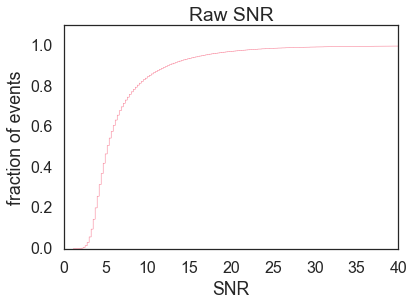

In [48]:
#baselined1 traces
allSNRs = []
for cell in range(1,numCells):
    for trial in range(numTrials):
         allSNRs.append(getSNR(traces,maxEvents,cell,trial))
allSNRs = np.hstack(allSNRs)
allSNRs = np.array(sorted(allSNRs))
print np.percentile(allSNRs,50)

plt.hist(allSNRs, bins = 500, histtype = 'step', cumulative = True, normed = True)
plt.xlim([0,40])
plt.ylim([0,1.1])
plt.title('Raw SNR')
plt.ylabel('fraction of events')
plt.xlabel('SNR')
plt.savefig('SNR_awake.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)

In [52]:
save_dict()

# Mask

In [50]:
maskPath = '/Users/Stan/Desktop/sp041216a/segmentation/maskThirdRound.dat'
mask = pickle.load(open(maskPath))
fname = '/Users/Stan/Desktop/sp041216a/h5/green/_e2_011_concatenated.h5'

2016-05-06 18:05:47,175 [WARNING] py.warnings, 107: /Users/Stan/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:107: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))

2016-05-06 18:05:47,178 [WARNING] py.warnings, 111: /Users/Stan/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from int16 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))



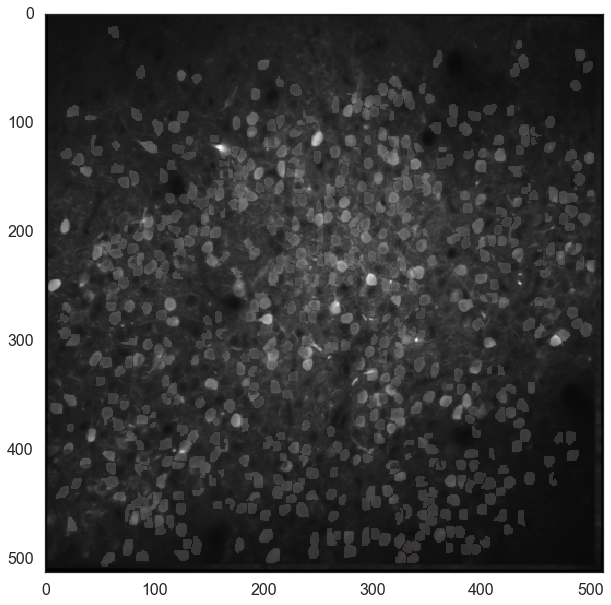

In [51]:
from skimage.util import img_as_ubyte
from skimage.transform import downscale_local_mean as localAve
import h5py
from scipy.stats.mstats import mquantiles

with h5py.File(fname, 'r+', ) as f:
    
    stack = f['current_statestep2/corrected'][...]
    
    

stack = img_as_ubyte(stack)
a,b = mquantiles(stack.flatten(),  prob=[0.02, 1])
stack[stack<a] = a
stack[stack>b] = b

subsampleFact = 10
stack = localAve(stack, (1,1,subsampleFact))

x,y,vidframes = stack.shape



from scipy.ndimage.measurements import center_of_mass as get_coords


# a,b = scipy.ndimage.label(mask)
# coords = get_coords(mask, a, range(b+1))
# coords = [(t[1],t[0]) for t in coords]
# print coords[cell]

#filter bad cells to bring mask locs in register with normed traces
# bad_cells = [866,864,327]

# cells = range(867)
# good_cells = [cell for cell in cells if cell not in bad_cells]
# coords = 

plt.figure(figsize = (10,10))
overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))
plt.imshow(stack[...].mean(2), cmap = 'Greys_r')
plt.imshow(overlay, cmap = 'Reds', alpha = 0.15)
#add cell location
#plt.gca().add_patch(plt.Circle(coords[cell],2, alpha = 1))
plt.savefig('mask_awake.png')

# Single cell movies

## Find cells with strong events, as well as outliers
 - Find those that have at least 3 strong events in a trial, that clear a particular threshold.
 - Thresh: 1.5 


In [149]:

def get_ave_event_by_cell(numCells, maxEventsArray, trialIDX, eventThresh):
    for cell in range(numCells):

        cellEvents = maxEventsArray[:,cell,trial]
        cellEvents = cellEvents[cellEvents>0]
        if len(cellEvents)>3:
            if cellEvents.mean()>eventThresh:
                yield cellEvents.mean(), cell


In [142]:
normed_traces = workflow_dict['normed_traces']['corrected_rois']

In [183]:
trialIndexingHelper

[(0, 10),
 (1, 11),
 (2, 12),
 (3, 13),
 (4, 14),
 (5, 15),
 (6, 16),
 (7, 17),
 (8, 18),
 (9, 19),
 (10, 20)]

In [184]:
trialIDX = 1
actualTrial = [_[1] for _ in trialIndexingHelper if _[0]==trialIDX][0]
print actualTrial

11


In [174]:
strongCells = [val[1] for val in get_ave_event_by_cell(numCells = numCells, 
                                                       maxEventsArray = workflow_dict['events']['max_events'], 
                                                       trialIDX=trialIDX, 
                                                       eventThresh = 1.1)]


99 1


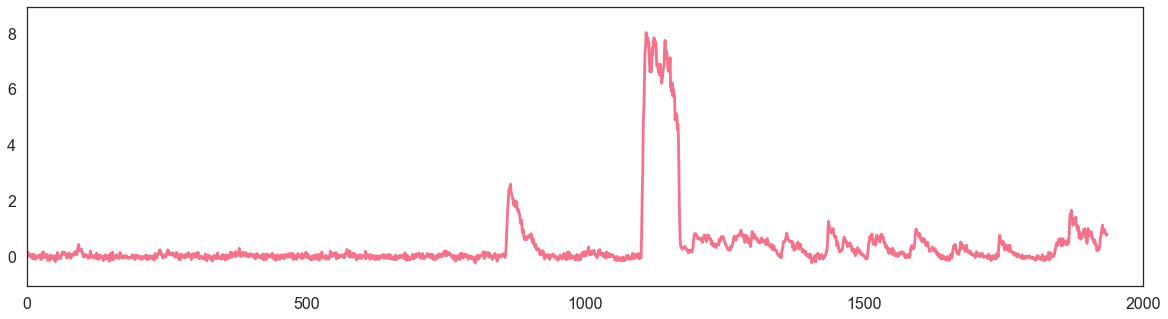

In [175]:
cell = np.random.permutation(strongCells)[0]
cell = 99
trialIDX =1
print cell, trialIDX 

plt.figure(figsize = (20,5))
plt.plot(normed_traces[:,cell,trialIDX])


In [53]:
save_dict()

In [161]:
picDir = "/Users/Stan/Desktop/temp/e2/"

In [192]:
import spUtils

cell = np.random.permutation(strongCells)[0]
cell = cell
print cell


coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
coords[0]=(0.0,0.0)
coords = [(int(t[1]),int(t[0])) for t in coords]

#Specify dimensions and location of zoom window around cell mask
halfRad = 25
yi = coords[cell][1]-halfRad
yf = coords[cell][1]+halfRad
xi = coords[cell][0]-halfRad
xf = coords[cell][0]+halfRad

#process mask overlay
overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))

import matplotlib.gridspec as gridspec
#from spUtils import xticksInSec

for frame in range(vidframes)[:]:
    #set display range for zoom window to correspond to that of entire FOV
    colormin = stack[...,frame].min()
    colormax = stack[...,frame].max()
    
    plt.figure(figsize=(16, 9))
    G = gridspec.GridSpec(4, 2)
    axes_1 = plt.subplot(G[:3, :1])
    axes_2 = plt.subplot(G[3:, :])
    axes_3 = plt.subplot(G[:3, 1:])

    
    axes_1.imshow(stack[yi:yf,xi:xf,frame], cmap = 'Greys_r',  aspect = 'auto', vmin = colormin, vmax = colormax)
    axes_1.imshow(overlay[yi:yf,xi:xf,], cmap = 'Reds', alpha = 0.15)
    axes_1.add_patch(plt.Circle((halfRad,halfRad),.5, alpha = 1))
    axes_1.set_ylabel('df/Fa')

    axes_3.imshow(stack[...,frame], cmap = 'Greys_r',  aspect = 'auto')
    axes_3.imshow(overlay, cmap = 'Reds', alpha = 0.15)
    axes_3.add_patch(plt.Circle(coords[cell],5, alpha = 1))
    

    axes_2 = plt.subplot(G[3:, :])
    axes_2.set_title('Cell {0} Trial {1}'.format(cell,actualTrial))
    axes_2.plot(normed_traces[:,cell, trialIDX], linewidth = 0.8)
    axes_2.axvline(range(0,normed_traces.shape[0],subsampleFact)[frame], linewidth = 1)
    axes_2.xticks = spUtils.xticksInSec(framerate = 7.55, secInterval = 30, plotLengthInFrames = normed_traces.shape[0])
    axes_2.set_ylim((-.2,3))
    axes_2.set_xlabel('sec')
    plt.savefig(picDir + 'pic_{}.png'.format(frame))
    plt.close()
from moviepy.editor import *
files=glob(picDir +'*.png')
files = sorted(files, key = lambda fname: int(fname.split('_')[-1].split('.png')[0]))
clip = ImageSequenceClip(files, fps=1)
# #ipython_display(clip)
clip.write_videofile("/Users/Stan/Desktop/temp/e2/e2_Cell_{0}_Trial_{1}.mp4".format(cell,actualTrial) ,fps=1, codec='mpeg4')

91
[MoviePy] >>>> Building video /Users/Stan/Desktop/temp/e2/e2_Cell_91_Trial_11.mp4
[MoviePy] Writing video /Users/Stan/Desktop/temp/e2/e2_Cell_91_Trial_11.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/Stan/Desktop/temp/e2/e2_Cell_91_Trial_11.mp4 



# Extra

In [ ]:
from scipy.stats.mstats import mquantiles

for trial in range(normed_traces.shape[2]):
    min_, max_ = mquantiles(normed_traces[...,trial].flatten(),  prob=[0.001, .999])
    plt.figure(figsize = (20,5))
    plt.imshow(normed_traces[...,trial].T, aspect = 'auto', vmin = min_, vmax = max_)
    plt.title('trial_{}'.format(trial+1))
    plt.colorbar()

# plt.figure(figsize = (20,5))
# plt.imshow(traces[...,trial].T, aspect = 'auto')
# plt.colorbar()

# plt.figure(figsize = (20,5))
# plt.imshow(normed_traces[...,trial].T, aspect = 'auto')
# plt.colorbar()

In [ ]:
#Inspect responder output.

trial = 3
interval = odor_info[trial]['pre_odor_post_interval'][odor+1]
plt.plot(normed_traces[interval[0]:interval[1], cell,trial])
plt.axvline(113)
plt.axvline(128)

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.imshow(traces[:,:,1].T, aspect = 'auto')

In [ ]:
df = epoch.loc[1]['0'].unstack()

In [ ]:
import plotly
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode() # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
    #combine all with seaborn and pandas. 
import cufflinks as cf
cf.go_offline()

In [ ]:
df.T.iplot(kind='heatmap', colorscale='greys', dimensions=(800, 1000))